# EfficientNet

https://colab.research.google.com/github/ayyucekizrak/EfficientNet-Transfer-Learning-Implementation/blob/master/EfficientNet_TransferLearning.ipynb#scrollTo=2SD6yma6ub9G
https://shirakonotempura.hatenablog.com/entry/2019/01/09/080534

https://arakan-pgm-ai.hatenablog.com/entry/2017/11/05/080000

## ①環境設定

In [ ]:
print(keras.__version__) #2.43
!pip show tensorflow #2.30

2.4.3
Name: tensorflow
Version: 2.3.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/deepstation/anaconda3/lib/python3.7/site-packages
Requires: gast, termcolor, grpcio, tensorflow-estimator, astunparse, scipy, absl-py, keras-preprocessing, tensorboard, wrapt, six, wheel, protobuf, opt-einsum, google-pasta, h5py, numpy
Required-by: 


In [ ]:
#!pip install tensorflow==1.15.0 #Grad CAM
#!pip install keras==2.2.4 #Grad CAM

In [ ]:
#!pip install --upgrade scipy
#!pip3 install -U tensorflow
#!pip install tensorflow==2.3.0
!pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-jqfohtmf
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-jqfohtmf
     |████████████████████████████████| 51kB 5.4MB/s 
  Created wheel for efficientnet: filename=efficientnet-1.1.1-cp36-none-any.whl size=18422 sha256=14c2d6dce3a2fa1612623c54b89c6421631f417aa9edba2d480c2c13125151db
  Stored in directory: /tmp/pip-ephem-wheel-cache-y2414pup/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import print_function

import warnings
warnings.filterwarnings("ignore")
import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import efficientnet.tfkeras as enet
#import keras_efficientnets as enet

import os, cv2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model, load_model
#from keras.layers.core import Dense
from keras.layers.pooling import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split



from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential, load_model, model_from_json
from tensorflow.keras import models, optimizers, layers
from tensorflow.keras.optimizers import SGD
from keras.layers import Flatten
from sklearn.model_selection import train_test_split  
from PIL import Image 
from tensorflow.keras.preprocessing import image as images
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K 

import numpy as np  
import glob  
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 
from sklearn import metrics
from sklearn.metrics import roc_curve
import requests


In [ ]:
#モデルを保存するディレクトリに移動
%cd /content/drive/My Drive/UC/model_efficientnet

/content/drive/My Drive/UC/model_efficientnet


In [ ]:
#******************************************************************************
#クラスの数、クラスの名前、学習画像のサイズ    
num_classes = 2
folder = ["Oval","Round"]
model_number = 4

#エポック、バッチサイズ
epochs = 15
batch_size = 4

#learning_num, data_set
learnig_num = 1
data_num = 6
train_set_num = 6
day = 20201207

#validationの合計数
#val_num = 160

#augmention
augmention = False

#******************************************************************************
if model_number == 0:
    image_size = 224
elif model_number == 1:
    image_size = 240
elif model_number == 2:
    image_size = 260
elif model_number == 3:
    image_size = 300
elif model_number == 4:
    image_size = 380
elif model_number == 5:
    image_size = 456
elif model_number == 6:
    image_size = 528
elif model_number == 7:
    image_size = 600
else:
    print('set model_number 0 to 7')
    
#学習データのディレクトリ
data_path = "/content/drive/My Drive/UC/" + "data_" + str(data_num) + "/train_" +  str(train_set_num)
print(data_path)
#モデルの名前
model_name = "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num)+".h5"
print(model_name)
#.jsonの名前
json_name = "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num) + ".json"
print(json_name)
#一時保存先のpath
save_path = "/content/drive/My Drive/save/" + "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num) + "_" + str(day)
print(save_path)

training_path = data_path + "/training/"
validation_path = data_path + "/validation/"
testing_path = data_path + "/testing/"

/content/drive/My Drive/UC/data_6/train_6
learning_1_data_6_train_set_6.h5
learning_1_data_6_train_set_6.json
/content/drive/My Drive/save/learning_1_data_6_train_set_6_20201207


## ②学習データの作成

事前にlocalPCでtrainig,validation,testingデータに分配する

※※水増しプログラム。一度目のみ使用

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2
"""
#kerasによるランダム法
datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0,
        height_shift_range=0,
        shear_range=0,
        zoom_range=0,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

for index, name in enumerate(folder):
    DATA_DIR = '/content/drive/My Drive/UC/data_2_train_set_1/training/' + name  # データディレクトリ
    SAVE_DIR = '/content/drive/My Drive/UC/data_2_train_set_1/training_augmented/'+name
    files = glob.glob(DATA_DIR + "/*.png")    
    for i, file in enumerate(files):
        IMAGE_NAME = file
        IMAGE_NAME = IMAGE_NAME.lstrip(DATA_DIR+"/")
        
        img_array = cv2.imread(file,)  # 画像読み込み
        img_array = img_array.reshape((1,) + img_array.shape)  # 4次元データに変換（flow()に渡すため）
        # 保存先ディレクトリが存在しない場合、作成する。
        if not os.path.exists(SAVE_DIR):
            os.makedirs(SAVE_DIR)
        # flow()により、ランダム変換したイメージのバッチを作成。
        # 指定したディレクトリに生成画像を保存する。
        
        datag = 0
        for batch in datagen.flow(img_array, batch_size=1,
                                  save_to_dir=SAVE_DIR, save_prefix=IMAGE_NAME, save_format='png'):
            print(SAVE_DIR +"/"+ IMAGE_NAME)
            datag += 1
            if datag == 3:
                break  # 停止しないと無限ループ

"""


#角度指定法
for index, name in enumerate(folder):
    dir = training_path + name
    files = glob.glob(dir + "/*.png")
    DATA_DIR = training_path + name
    SAVE_DIR = data_path + '/training_augmented/' + name
    if not os.path.exists(SAVE_DIR):
            os.makedirs(SAVE_DIR)

    for i, file in enumerate(files):
        IMAGE_NAME = file
        IMAGE_NAME = IMAGE_NAME.lstrip(DATA_DIR)
        if name == "Normal":
            IMAGE_NAME = "N_" + IMAGE_NAME
        if name == "Atypical":
            IMAGE_NAME = "A_" + IMAGE_NAME
        if name == "Dysplasia":
            IMAGE_NAME = "D_" + IMAGE_NAME
        if name == "CIS":
            IMAGE_NAME = "C_" + IMAGE_NAME
        IMAGE_NAME =IMAGE_NAME.rstrip(".png")
        print(IMAGE_NAME)
       
        img = Image.open(file)
        img.save(SAVE_DIR + '/' + IMAGE_NAME +'_r00.png')

        #tmp = img.transpose(Image.FLIP_LEFT_RIGHT)
        #tmp.save(SAVE_DIR + '/' + IMAGE_NAME +'_r01.png')
        #tmp = img.transpose(Image.FLIP_TOP_BOTTOM)
        #tmp.save(SAVE_DIR + '/' + IMAGE_NAME +'_r02.png')
        #tmp = img.transpose(Image.ROTATE_90)
        #tmp.save(SAVE_DIR + '/' + IMAGE_NAME +'_r03.png')
        #tmp = img.transpose(Image.ROTATE_180)
        #tmp.save(SAVE_DIR + '/' + IMAGE_NAME +'_r04.png')
        #tmp = img.transpose(Image.ROTATE_270)
        #tmp.save(SAVE_DIR + '/' + IMAGE_NAME +'_r05.png')
        
        tmp = img.rotate(90)
        tmp.save(SAVE_DIR + '/' + IMAGE_NAME +'_r06.png')
        #tmp = img.rotate(180)
        #tmp.save(SAVE_DIR + '/' + IMAGE_NAME +'_r07.png')
        #tmp = img.rotate(270)
        #tmp.save(SAVE_DIR + '/' + IMAGE_NAME +'_r08.png')
        #tmp = img.rotate(360)
        #tmp.save(SAVE_DIR + '/' + IMAGE_NAME +'_r10.png')

print("DONE!")

N_15_b_66
N_5_b_54
N_10_b_0
N_10_b_1
N_10_b_10
N_10_b_11
N_10_b_12
N_10_b_13
N_10_b_14
N_10_b_15
N_10_b_16
N_10_b_17
N_10_b_18
N_10_b_19
N_10_b_2
N_10_b_20
N_10_b_21
N_10_b_22
N_10_b_23
N_1_b_33
N_1_b_34
N_1_b_35
N_1_b_36
N_1_b_37
N_1_b_38
N_1_b_39
N_1_b_4
N_1_b_40
N_1_b_41
N_1_b_42
N_1_b_43
N_1_b_44
N_1_b_45
N_1_b_46
N_1_b_47
N_1_b_48
N_1_b_49
N_1_b_5
N_1_b_50
N_1_b_52
N_1_b_53
N_1_b_54
N_1_b_55
N_1_b_56
N_1_b_57
N_1_b_58
N_1_b_59
N_1_b_6
N_1_b_60
N_1_b_61
N_1_b_62
N_1_b_63
N_1_b_64
N_1_b_65
N_1_b_66
N_1_b_67
N_1_b_68
N_1_b_69
N_1_b_7
N_1_b_71
N_1_b_72
N_1_b_73
N_1_b_74
N_1_b_75
N_1_b_76
N_1_b_77
N_1_b_78
N_1_b_79
N_1_b_8
N_1_b_80
N_1_b_81
N_1_b_82
N_1_b_83
N_1_b_84
N_1_b_85
N_1_b_86
N_1_b_87
N_1_b_88
N_1_b_89
N_1_b_90
N_1_b_91
N_1_b_92
N_1_b_93
N_1_b_94
N_1_b_95
N_1_b_96
N_1_b_97
N_1_b_98
N_1_b_99
N_0_b_0
N_0_b_1
N_0_b_10
N_0_b_100
N_0_b_101
N_0_b_102
N_0_b_103
N_0_b_104
N_0_b_105
N_0_b_106
N_b_21
N_b_22
N_b_23
N_b_24
N_b_25
N_b_26
N_b_27
N_b_28
N_b_29
N_b_3
N_b_30
N_b_31
N_b_32
N_b_

In [ ]:
x_train = []
y_train = []
x_test = []
y_test = []

for index, name in enumerate(folder):
    if augmention:
        dir = data_path + "/training_augmented/" + name
    else:
        dir = training_path + name


    files = glob.glob(dir + "/*.png")    
    for i, file in enumerate(files):    
        image = Image.open(file)                       
        image = image.convert("RGB")    
        image = image.resize((image_size, image_size))
        data = np.asarray(image)        
        x_train.append(data)  
        y_train.append(index) 
        print("training_" + str(name) + ":　"+ str(i))

x_train = np.array(x_train)   
y_train = np.array(y_train)  


for index, name in enumerate(folder):
    dir = testing_path + name
    files = glob.glob(dir + "/*.png")    
    for i, file in enumerate(files):    
        image = Image.open(file)                       
        image = image.convert("RGB")    
        image = image.resize((image_size, image_size))
        data = np.asarray(image)        
        x_test.append(data)  
        y_test.append(index)
        print("testing_" + str(name) + ":　"+ str(i)) 

x_test = np.array(x_test)
y_test = np.array(y_test)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# ｙ　ラベルをワンホット表現に
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

training_Oval:　0
training_Oval:　1
training_Oval:　2
training_Oval:　3
training_Oval:　4
training_Oval:　5
training_Oval:　6
training_Oval:　7
training_Oval:　8
training_Oval:　9
training_Oval:　10
training_Oval:　11
training_Oval:　12
training_Oval:　13
training_Oval:　14
training_Oval:　15
training_Oval:　16
training_Oval:　17
training_Oval:　18
training_Oval:　19
training_Oval:　20
training_Oval:　21
training_Oval:　22
training_Oval:　23
training_Oval:　24
training_Oval:　25
training_Oval:　26
training_Oval:　27
training_Oval:　28
training_Oval:　29
training_Oval:　30
training_Oval:　31
training_Oval:　32
training_Oval:　33
training_Oval:　34
training_Oval:　35
training_Oval:　36
training_Oval:　37
training_Oval:　38
training_Oval:　39
training_Oval:　40
training_Oval:　41
training_Oval:　42
training_Oval:　43
training_Oval:　44
training_Oval:　45
training_Oval:　46
training_Oval:　47
training_Oval:　48
training_Oval:　49
training_Oval:　50
training_Oval:　51
training_Oval:　52
training_Oval:　53
training_Oval:　54
training_Oval:　55
tr

## ③学習フェーズ

### モデルの構築

In [ ]:
from keras.backend import sigmoid

class SwishActivation(Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

In [ ]:
#base_model = model_name(weights='noisy-student',input_shape=x.shape[1:], include_top=False)
if model_number == 0:
    model = enet.EfficientNetB0(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 1:
    model = enet.EfficientNetB1(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 2:
    model = enet.EfficientNetB2(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 3:
    model = enet.EfficientNetB3(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 4:
    model = enet.EfficientNetB4(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 5:
    model = enet.EfficientNetB5(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 6:
    model = enet.EfficientNetB6(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 7:
    model = enet.EfficientNetB7(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
else:
    print('set model_number 0 to 7')


# Adding 2 fully-connected layers to B0.
x = model.output

x = BatchNormalization()(x)
x = Dropout(0.7)(x)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)

# Output layer
predictions = Dense(num_classes, activation="softmax")(x)

model = Model(inputs = model.input, outputs = predictions)

model.summary()

71892992/71892840 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 190, 190, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 190, 190, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 190, 190, 48) 0           stem_bn[0][0]                    
_____________________________

In [ ]:

# ModelCheckpoint
weights_dir='./weights/'
if os.path.exists(weights_dir)==False:os.mkdir(weights_dir)
checkpoint = ModelCheckpoint(
                    filepath="learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num) +  "_batch_" + str(batch_size) + "_{epoch:02d}.h5",
                    monitor='val_loss',
                    save_best_only=False,
                    period=1,
                )

# reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, verbose=1,)
# log for TensorBoard
logging = TensorBoard(log_dir="log/")

mcp_save = ModelCheckpoint('/content/drive/My Drive/UC/model_EfficientNet/EnetB7_CIFAR10_TL.h5', save_best_only=False)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.0001),
              metrics=['accuracy'])

### 学習

In [ ]:
print("Training....")
hist = model.fit(x_train, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data = (x_test, y_test),
                 callbacks=[checkpoint,reduce_lr, logging],
                 shuffle=True,
                 verbose=1)

Training....
Epoch 1/15
77/77 [==============================] - 53s 394ms/step - loss: 0.8586 - accuracy: 0.4234 - val_loss: 0.5635 - val_accuracy: 1.0000
Epoch 2/15
77/77 [==============================] - 25s 324ms/step - loss: 0.7587 - accuracy: 0.5534 - val_loss: 0.5498 - val_accuracy: 0.9610
Epoch 3/15
77/77 [==============================] - 26s 334ms/step - loss: 0.6630 - accuracy: 0.6280 - val_loss: 0.4788 - val_accuracy: 0.9740
Epoch 4/15
77/77 [==============================] - 26s 341ms/step - loss: 0.6993 - accuracy: 0.6435 - val_loss: 0.5497 - val_accuracy: 0.7532
Epoch 5/15
77/77 [==============================] - 26s 335ms/step - loss: 0.6325 - accuracy: 0.6795 - val_loss: 0.2523 - val_accuracy: 1.0000
Epoch 6/15
77/77 [==============================] - 26s 337ms/step - loss: 0.4834 - accuracy: 0.7608 - val_loss: 0.2110 - val_accuracy: 1.0000
Epoch 7/15
77/77 [==============================] - 26s 337ms/step - loss: 0.4717 - accuracy: 0.7916 - val_loss: 0.1483 - val_acc

### モデルを保存/ロード

モデルの保存

In [ ]:
#仮保存
model_json = model.to_json()
with open(json_name, "w") as json_file:
    json_file.write(model_json)

model.save_weights(model_name)


#saveフォルダに保存
if not os.path.exists(save_path):
  os.makedirs(save_path)

model_json = model.to_json()
with open(save_path + "/" + json_name, "w") as json_file:
    json_file.write(model_json)

model.save_weights(save_path + "/" + model_name)

モデルを開く

In [ ]:
#json_file = open(json_name, 'r')
#model_json = json_file.read()
#model = model_from_json(model_json)
# load weights into new model
model.load_weights(model_name)

model.compile(
    optimizer = Adam(),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

## ④評価フェーズ

＜評価数値＞

⓪Loss:損失関数

①accuracy：正解率　TP+TN / TP + TN + FP + FN

②P(precision)：適合率　TP / TP + FP
(=精度、陽性反応的中度、)

③R(recall)：再現率　TP / FN +TP
（＝Sensitivity：感度）

④F(F-score)：F値　2* precision * recall / precision + recall

⑤ROC-AUC：ROC曲線の下面積

⑥Spe(Specificity)：特異度　TN / TN + FN 

### モデルの評価(validation)

### 2class

24/24 [==============================] - 4s 65ms/step - loss: 0.0318 - accuracy: 1.0000
Test loss: 0.03177689388394356
Test accuracy: 1.0



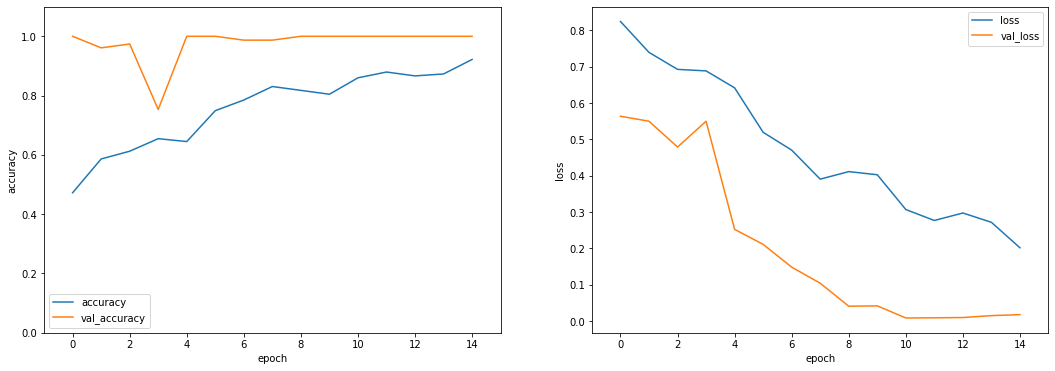

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


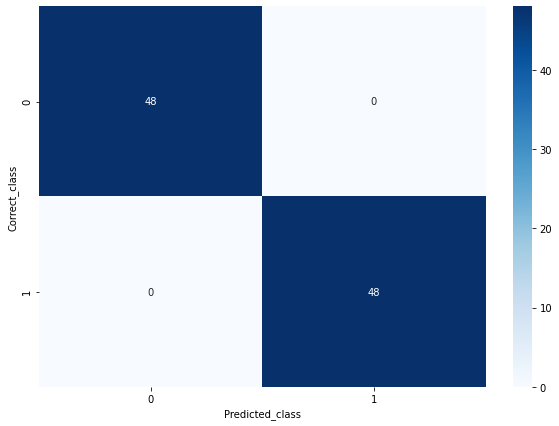

In [ ]:

###　Test loss, Test accuracy, AUC, True Positive, True Negative, False Positive, False Negative
scores = model.evaluate(x_test, y_test, batch_size = batch_size, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print("")


### Plot accuracy & loss
plt.figure(figsize = (18,6))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(hist.history["accuracy"], label = "accuracy")
plt.plot(hist.history["val_accuracy"], label = "val_accuracy")
#plt.xticks(np.arange())
#plt.yticks(np.arange())
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.xlim(-1, epochs)
plt.ylim(0.0, 1.1)
#plt.title("")
plt.legend(loc = "best")
#plt.grid(color = 'gray', alpha = 0.2)

# loss
plt.subplot(1, 2, 2)
plt.plot(hist.history["loss"], label = "loss")
plt.plot(hist.history["val_loss"], label = "val_loss")
#plt.xticks(np.arange())
#plt.yticks(np.arange())
plt.xlabel("epoch")
plt.ylabel("loss")
plt.xlim(-1, epochs)
#plt.title("")
plt.legend(loc = "best")
#plt.grid(color = 'gray', alpha = 0.2)
plt.show()




import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cmx, cmap="Blues", annot=True)
    plt.xlabel("Predicted_class")
    plt.ylabel("Correct_class")
    plt.show()


import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cmx, cmap="Blues", annot=True)
    plt.xlabel("Predicted_class")
    plt.ylabel("Correct_class")
    plt.show()


predicted_class = []
prediction_y = model.predict(x_test)
for i in range(len(prediction_y)):
  if prediction_y[i][0] >= prediction_y[i][1]:
    predicted_class.append(0)
  elif prediction_y[i][1] >= prediction_y[i][0]:
    predicted_class.append(1)
  else:
    print("error")
print(predicted_class)

  
o_num = glob.glob(testing_path + 'Oval/*.png')
r_num = glob.glob(testing_path + 'Round/*.png')
label_class = []
for i in range(len(o_num)):
  label_class.append(0)
for i in range(len(r_num)):
  label_class.append(1)

print(label_class)

print_cmx(label_class, predicted_class)

In [ ]:
x_test = []
y_test = []
for index, name in enumerate(folder):
    if augmention:
        dir = data_path + "/training_augmented/" + name
    else:
        dir = training_path + name
for index, name in enumerate(folder):
    dir = testing_path + name
    files = glob.glob(dir + "/*.png")    
    for i, file in enumerate(files):    
        image = Image.open(file)                       
        image = image.convert("RGB")    
        image = image.resize((image_size, image_size))
        data = np.asarray(image)        
        x_test.append(data)  
        y_test.append(index)
        print("testing_" + str(name) + ":　"+ str(i)) 
x_test = np.array(x_test)
y_test = np.array(y_test)
x_test = x_test.astype('float32')
x_test /= 255
# ｙ　ラベルをワンホット表現に
y_test = keras.utils.to_categorical(y_test, num_classes)
print(x_test.shape[0], 'test samples')
prediction_y = model.predict(x_test)
predicted_class = []


l_num = glob.glob(testing_path + 'Round/*.png')
h_num = glob.glob(testing_path + 'Oval/*.png')
label_class = []
for i in range(len(l_num)):
  label_class.append(0)
for i in range(len(h_num)):
  label_class.append(1)

result_matrix = np.empty((len(prediction_y)+1,4),dtype='U100')
result_matrix[0,0] = "label"
result_matrix[0,1] = 'A'
result_matrix[0,2] = "B"

for i in range(len(prediction_y)):
    result_matrix[i+1,0] = str(label_class[i])
    result_matrix[i+1,1] = str(prediction_y[i][0])
    result_matrix[i+1,2] = str(prediction_y[i][1])

np.savetxt("shape.csv" ,result_matrix, delimiter=',',fmt='%s')

testing_Oval:　0
testing_Oval:　1
testing_Oval:　2
testing_Oval:　3
testing_Oval:　4
testing_Oval:　5
testing_Oval:　6
testing_Oval:　7
testing_Oval:　8
testing_Oval:　9
testing_Oval:　10
testing_Oval:　11
testing_Oval:　12
testing_Oval:　13
testing_Oval:　14
testing_Oval:　15
testing_Oval:　16
testing_Oval:　17
testing_Oval:　18
testing_Oval:　19
testing_Oval:　20
testing_Oval:　21
testing_Oval:　22
testing_Oval:　23
testing_Oval:　24
testing_Oval:　25
testing_Oval:　26
testing_Oval:　27
testing_Oval:　28
testing_Oval:　29
testing_Oval:　30
testing_Oval:　31
testing_Oval:　32
testing_Oval:　33
testing_Oval:　34
testing_Oval:　35
testing_Oval:　36
testing_Oval:　37
testing_Oval:　38
testing_Oval:　39
testing_Oval:　40
testing_Oval:　41
testing_Oval:　42
testing_Oval:　43
testing_Oval:　44
testing_Oval:　45
testing_Oval:　46
testing_Oval:　47
testing_Oval:　48
testing_Oval:　49
testing_Oval:　50
testing_Oval:　51
testing_Oval:　52
testing_Oval:　53
testing_Oval:　54
testing_Oval:　55
testing_Oval:　56
testing_Oval:　57
testing_Oval:　58
testing

### 3class

128/128 [==============================] - 68s 532ms/step - loss: 0.3385 - accuracy: 0.8667
Test loss: 0.33846086263656616
Test accuracy: 0.8666666746139526



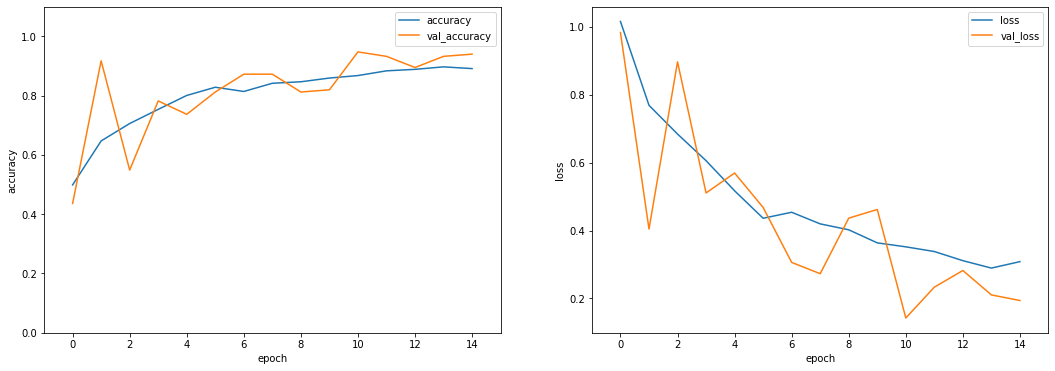

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

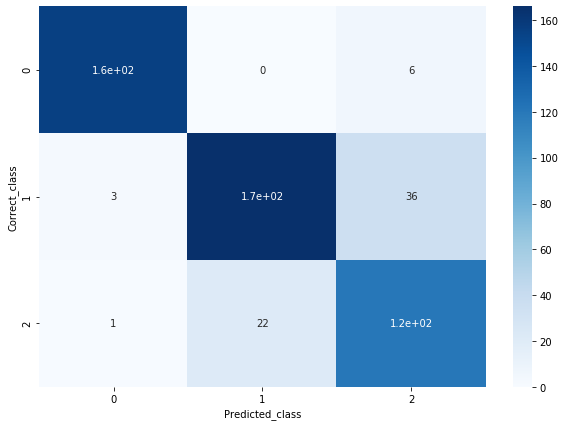

In [ ]:

###　Test loss, Test accuracy, AUC, True Positive, True Negative, False Positive, False Negative
scores = model.evaluate(x_test, y_test, batch_size = batch_size, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print("")

"""
test_y = []
predict_y = []
prediction_y = model.predict(x_test[0:val_num])
j = 1
for i in range(0,int(val_num/2)):
  if prediction_y[i][0]>=0.5 :
    predict_y.append(1)
  else :
    predict_y.append(0)
  test_y.append(j)
j = 0 
for i in range(int(val_num/2),val_num):
  if prediction_y[i][0]>0.5 :
    predict_y.append(1)
  else :
    predict_y.append(0)
  test_y.append(j)
print(test_y)
print(predict_y)
print("")

FC_TP = 0
FC_TN = 0
FC_FP = 0
FC_FN = 0

Pap_TP = 0
Pap_TN = 0
Pap_FP = 0
Pap_FN = 0

## FC
for i in range(0, val_num):
  if test_y[i] == 1 and predict_y[i] == 1:
    FC_TP += 1
  if test_y[i] == 0 and predict_y[i] == 0:
    FC_TN += 1
  if test_y[i] == 0 and predict_y[i] == 1:
    FC_FP += 1
  if test_y[i] == 1 and predict_y[i] == 0:
    FC_FN += 1

precision =FC_TP / (FC_TP + FC_FP)
recall = FC_TP / (FC_FN + FC_TP)
Specificity =FC_TN / (FC_TN + FC_FN)

print('FC_TP：',FC_TP)
print('FC_TN：', FC_TN)
print('FC_FP：', FC_FP)
print('FC_FN：', FC_FN)
print("")

print('FC_Precision(適合率)：', precision)
print('FC_Recall(再現率)：', recall)
print('FC_Specificity(特異度)：', Specificity)
print('FC_F-score(F値)：', (2 * precision * recall) / (precision + recall))
print("")

## Pap
for i in range(0, val_num):
  if test_y[i] == 0 and predict_y[i] == 0:
    Pap_TP += 1
  if test_y[i] == 1 and predict_y[i] == 1:
    Pap_TN += 1
  if test_y[i] == 1 and predict_y[i] == 0:
    Pap_FP += 1
  if test_y[i] == 0 and predict_y[i] == 1:
    Pap_FN += 1

precision =Pap_TP / (Pap_TP + Pap_FP)
recall = Pap_TP / (Pap_FN + Pap_TP)
Specificity =Pap_TN / (Pap_TN + Pap_FN)

print('Pap_TP：',Pap_TP)
print('Pap_TN：', Pap_TN)
print('Pap_FP：', Pap_FP)
print('Pap_FN：', Pap_FN)
print("")

print('Pap_Precision(適合率)：', precision)
print('Pap_Recall(再現率)：', recall)
print('Pap_Specificity(特異度)：', Specificity)
print('Pap_F-score(F値)：', (2 * precision * recall) / (precision + recall))
print("")
"""

### Plot accuracy & loss
plt.figure(figsize = (18,6))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(hist.history["accuracy"], label = "accuracy")
plt.plot(hist.history["val_accuracy"], label = "val_accuracy")
#plt.xticks(np.arange())
#plt.yticks(np.arange())
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.xlim(-1, epochs)
plt.ylim(0.0, 1.1)
#plt.title("")
plt.legend(loc = "best")
#plt.grid(color = 'gray', alpha = 0.2)

# loss
plt.subplot(1, 2, 2)
plt.plot(hist.history["loss"], label = "loss")
plt.plot(hist.history["val_loss"], label = "val_loss")
#plt.xticks(np.arange())
#plt.yticks(np.arange())
plt.xlabel("epoch")
plt.ylabel("loss")
plt.xlim(-1, epochs)
#plt.title("")
plt.legend(loc = "best")
#plt.grid(color = 'gray', alpha = 0.2)
plt.show()





import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cmx, cmap="Blues", annot=True)
    plt.xlabel("Predicted_class")
    plt.ylabel("Correct_class")
    plt.show()


predicted_class = []
prediction_y = model.predict(x_test)
for i in range(len(prediction_y)):
  if prediction_y[i][0] >= prediction_y[i][1] and prediction_y[i][0] >= prediction_y[i][2]:
    predicted_class.append(0)
  if prediction_y[i][1] >= prediction_y[i][0] and prediction_y[i][1] >= prediction_y[i][2]:
    predicted_class.append(1)
  if prediction_y[i][2] >= prediction_y[i][0] and prediction_y[i][2] >= prediction_y[i][1]:
    predicted_class.append(2)
  else:
    print("error")
print(predicted_class)

  
n_num = glob.glob(validation_path + 'Normal/*.png')
a_num = glob.glob(validation_path + 'Atypical/*.png')
#d_num = glob.glob(validation_path + 'Dysplasia/*.png')
c_num = glob.glob(validation_path + 'CIS/*.png')
label_class = []
for i in range(len(n_num)):
  label_class.append(0)
for i in range(len(a_num)):
  label_class.append(1)
#for i in range(len(d_num)):
#  label_class.append(2)
for i in range(len(c_num)):
  label_class.append(2)
print(label_class)
  

print_cmx(label_class, predicted_class)

### 4class

157/157 [==============================] - 57s 362ms/step - loss: 1.0863 - accuracy: 0.6204
Test loss: 1.0863457918167114
Test accuracy: 0.620414674282074



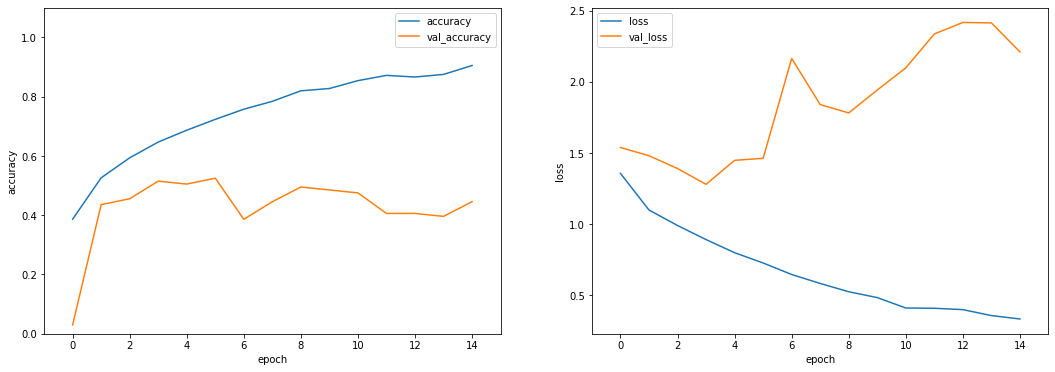

[2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 1, 3, 3, 1, 1, 2, 0, 2, 2, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 1, 1, 1, 1, 2, 3, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1, 3, 1, 2, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 0, 2, 0, 2, 0, 1, 2, 1, 1, 1, 0, 1, 0, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 3, 3, 2, 3, 2, 1, 1, 2, 2, 

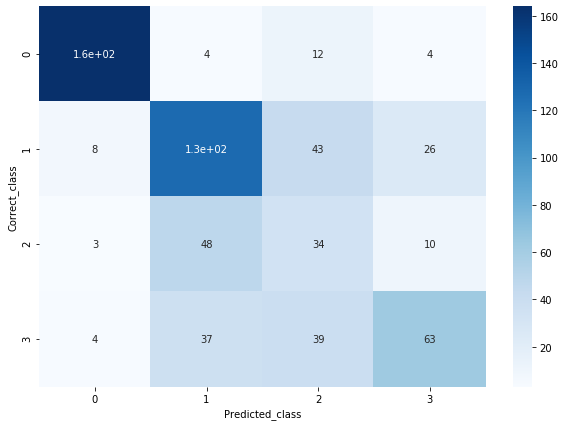

In [ ]:

###　Test loss, Test accuracy, AUC, True Positive, True Negative, False Positive, False Negative
scores = model.evaluate(x_test, y_test, batch_size = batch_size, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print("")

"""
test_y = []
predict_y = []
prediction_y = model.predict(x_test[0:val_num])
j = 1
for i in range(0,int(val_num/2)):
  if prediction_y[i][0]>=0.5 :
    predict_y.append(1)
  else :
    predict_y.append(0)
  test_y.append(j)
j = 0 
for i in range(int(val_num/2),val_num):
  if prediction_y[i][0]>0.5 :
    predict_y.append(1)
  else :
    predict_y.append(0)
  test_y.append(j)
print(test_y)
print(predict_y)
print("")

FC_TP = 0
FC_TN = 0
FC_FP = 0
FC_FN = 0

Pap_TP = 0
Pap_TN = 0
Pap_FP = 0
Pap_FN = 0

## FC
for i in range(0, val_num):
  if test_y[i] == 1 and predict_y[i] == 1:
    FC_TP += 1
  if test_y[i] == 0 and predict_y[i] == 0:
    FC_TN += 1
  if test_y[i] == 0 and predict_y[i] == 1:
    FC_FP += 1
  if test_y[i] == 1 and predict_y[i] == 0:
    FC_FN += 1

precision =FC_TP / (FC_TP + FC_FP)
recall = FC_TP / (FC_FN + FC_TP)
Specificity =FC_TN / (FC_TN + FC_FN)

print('FC_TP：',FC_TP)
print('FC_TN：', FC_TN)
print('FC_FP：', FC_FP)
print('FC_FN：', FC_FN)
print("")

print('FC_Precision(適合率)：', precision)
print('FC_Recall(再現率)：', recall)
print('FC_Specificity(特異度)：', Specificity)
print('FC_F-score(F値)：', (2 * precision * recall) / (precision + recall))
print("")

## Pap
for i in range(0, val_num):
  if test_y[i] == 0 and predict_y[i] == 0:
    Pap_TP += 1
  if test_y[i] == 1 and predict_y[i] == 1:
    Pap_TN += 1
  if test_y[i] == 1 and predict_y[i] == 0:
    Pap_FP += 1
  if test_y[i] == 0 and predict_y[i] == 1:
    Pap_FN += 1

precision =Pap_TP / (Pap_TP + Pap_FP)
recall = Pap_TP / (Pap_FN + Pap_TP)
Specificity =Pap_TN / (Pap_TN + Pap_FN)

print('Pap_TP：',Pap_TP)
print('Pap_TN：', Pap_TN)
print('Pap_FP：', Pap_FP)
print('Pap_FN：', Pap_FN)
print("")

print('Pap_Precision(適合率)：', precision)
print('Pap_Recall(再現率)：', recall)
print('Pap_Specificity(特異度)：', Specificity)
print('Pap_F-score(F値)：', (2 * precision * recall) / (precision + recall))
print("")
"""

### Plot accuracy & loss
plt.figure(figsize = (18,6))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(hist.history["accuracy"], label = "accuracy")
plt.plot(hist.history["val_accuracy"], label = "val_accuracy")
#plt.xticks(np.arange())
#plt.yticks(np.arange())
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.xlim(-1, epochs)
plt.ylim(0.0, 1.1)
#plt.title("")
plt.legend(loc = "best")
#plt.grid(color = 'gray', alpha = 0.2)

# loss
plt.subplot(1, 2, 2)
plt.plot(hist.history["loss"], label = "loss")
plt.plot(hist.history["val_loss"], label = "val_loss")
#plt.xticks(np.arange())
#plt.yticks(np.arange())
plt.xlabel("epoch")
plt.ylabel("loss")
plt.xlim(-1, epochs)
#plt.title("")
plt.legend(loc = "best")
#plt.grid(color = 'gray', alpha = 0.2)
plt.show()





import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cmx, cmap="Blues", annot=True)
    plt.xlabel("Predicted_class")
    plt.ylabel("Correct_class")
    plt.show()


predicted_class = []
prediction_y = model.predict(x_test)

for i in range(len(prediction_y)):
  if prediction_y[i][0] >= prediction_y[i][1] and prediction_y[i][0] >= prediction_y[i][2] and prediction_y[i][0] >= prediction_y[i][3]:
    predicted_class.append(0)
  elif prediction_y[i][1] >= prediction_y[i][0] and prediction_y[i][1] >= prediction_y[i][2] and prediction_y[i][1] >= prediction_y[i][3]:
    predicted_class.append(1)
  elif prediction_y[i][2] >= prediction_y[i][0] and prediction_y[i][2] >= prediction_y[i][1] and prediction_y[i][2] >= prediction_y[i][3]:
    predicted_class.append(2)
  elif prediction_y[i][3] >= prediction_y[i][0] and prediction_y[i][3] >= prediction_y[i][1] and prediction_y[i][3] >= prediction_y[i][2]:
    predicted_class.append(3)
  else:
    print("error")
print(predicted_class)

  
n_num = glob.glob(testing_path + 'Normal/*.png')
a_num = glob.glob(testing_path + 'Atypical/*.png')
d_num = glob.glob(testing_path + 'Dysplasia/*.png')
c_num = glob.glob(testing_path + 'CIS/*.png')
label_class = []
for i in range(len(n_num)):
  label_class.append(0)
for i in range(len(a_num)):
  label_class.append(1)
for i in range(len(d_num)):
  label_class.append(2)
for i in range(len(c_num)):
  label_class.append(3)
print(label_class)

print_cmx(label_class, predicted_class)

### Score CAM

In [ ]:
print(model.layers[0].output_shape[0])
print(model.layers[0].output_shape[:1])
input_shape = model.layers[0].output_shape[0]
print(input_shape[1:3])

(None, 380, 380, 3)
[(None, 380, 380, 3)]
(380, 380)


In [ ]:
import cv2
import numpy as np
from keras.models import Model

def ScoreCam(model, img_array, layer_name, max_N=-1):

    cls = np.argmax(model.predict(img_array))
    act_map_array = Model(inputs=model.input, outputs=model.get_layer(layer_name).output).predict(img_array)

    # extract effective maps
    if max_N != -1:
        act_map_std_list = [np.std(act_map_array[0,:,:,k]) for k in range(act_map_array.shape[3])]
        unsorted_max_indices = np.argpartition(-np.array(act_map_std_list), max_N)[:max_N]
        max_N_indices = unsorted_max_indices[np.argsort(-np.array(act_map_std_list)[unsorted_max_indices])]
        act_map_array = act_map_array[:,:,:,max_N_indices]

    input_shape = model.layers[0].output_shape[0]  # get input shape
    # 1. upsampled to original input size
    act_map_resized_list = [cv2.resize(act_map_array[0,:,:,k], input_shape[1:3], interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[3])]
    # 2. normalize the raw activation value in each activation map into [0, 1]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)
    # 3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
    masked_input_list = []
    for act_map_normalized in act_map_normalized_list:
        masked_input = np.copy(img_array)
        for k in range(3):
            masked_input[0,:,:,k] *= act_map_normalized
        masked_input_list.append(masked_input)
    masked_input_array = np.concatenate(masked_input_list, axis=0)
    # 4. feed masked inputs into CNN model and softmax
    pred_from_masked_input_array = softmax(model.predict(masked_input_array))
    # 5. define weight as the score of target class
    weights = pred_from_masked_input_array[:,cls]
    # 6. get final class discriminative localization map as linear weighted combination of all activation maps
    cam = np.dot(act_map_array[0,:,:,:], weights)
    cam = np.maximum(0, cam)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0

    return cam

def softmax(x):
    f = np.exp(x)/np.sum(np.exp(x), axis = 1, keepdims = True)
    return f

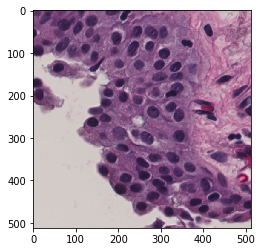

In [ ]:
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

orig_img = np.array(load_img('/media/deepstation/Transcend/data/data_2/train_1/testing/Atypical/A_222_b_0.png'),dtype=np.uint8)
plt.imshow(orig_img)
plt.show()

In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 190, 190, 48) 1296        input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 190, 190, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 190, 190, 48) 0           stem_bn[0][0]                    
_______________________________________________________________________________________

(None, 380, 380, 3)


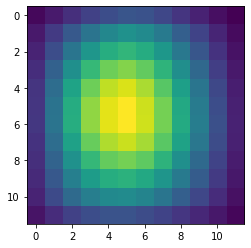

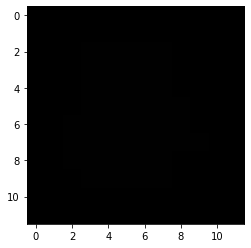

In [ ]:
#from gradcamutils import read_and_preprocess_img
import matplotlib.pyplot as plt

def read_and_preprocess_img(path, size=(image_size,image_size)):
    img = load_img(path, target_size=size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x
def superimpose(original_img_path, cam, emphasize=False):
    
    img_bgr = cv2.imread(original_img_path)

    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, 0.5, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb
  
img_array = read_and_preprocess_img('/media/deepstation/Transcend/data/data_2/train_1/testing/Atypical/A_222_b_0.png', size=(image_size,image_size))
layer_name = "block7b_activation"

score_cam = ScoreCam(model,img_array,layer_name)
score_cam_superimposed = superimpose('/media/deepstation/Transcend/data/data_2/train_1/testing/Atypical/A_222_b_0.png', score_cam)
plt.imshow(score_cam_superimposed)
plt.show()

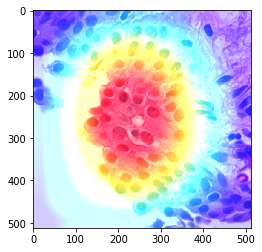

https://github.com/tabayashi0117/Score-CAM/blob/master/gradcamutils.py

## ⑤推論フェーズ

### すべて表示

validation

In [ ]:
val_num =690

labels = np.array([
   'Normal','AU', 'Dysplasia', 'CIS'
])
vertical_num = val_num/10
true_classes = np.argmax(y_test[0:val_num], axis = 1)
plt.figure(figsize = (15, vertical_num*2))
for i in range(val_num):
    plt.subplot(vertical_num, 10, i + 1)
    plt.axis("off")
    plt.title(labels[true_classes[i]])
    plt.imshow(x_test[i])
plt.show()

In [ ]:

vertical_num = val_num/10
pred_classes=np.argmax(model.predict(x_test[0:val_num]),axis=1)

# テストデータ30件の予測確率
pred_probs = np.max(model.predict(x_test[0:val_num]),axis=1)
pred_probs = ['{:.4f}'.format(i) for i in pred_probs]

# testデータ30件の画像と予測ラベル＆予測確率を出力
plt.figure(figsize = (15, vertical_num*2))
for i in range(val_num):
    plt.subplot(vertical_num, 10, i + 1)
    plt.axis("off")
    if pred_classes[i] == true_classes[i]:
        plt.title(labels[pred_classes[i]] + '\n' + pred_probs[i])
    else:
        plt.title(labels[pred_classes[i]] + '\n' + pred_probs[i], color = "red")
    plt.imshow(x_test[i])
plt.show()

testing

### 個別に表示

In [ ]:
from keras.preprocessing import image
def predict_picture(img_path):
    #img = image.load_img("/content/drive/My Drive/VGG16/dog_cat/test/cat1.jpg"), target_size=(224, 224))
    img = keras.preprocessing.image.load_img(img_path, target_size=(image_size, image_size))
    
    # 読み込んだPIL形式の画像をarrayに変換
    ary = image.img_to_array(img)

    #サンプル数の次元を1つ増やし四次元テンソルに
    ary = np.expand_dims(ary, axis=0)

    pred = model.predict(preprocess_input(ary))
    if pred[0][0] > pred[0][1] :
        print("classification")
        print(">>>Follicular Carcinoma")
        print("probability")
        print(pred[0][0])
    else :
        print("classification")
        print(">>>Papillary Carcinoma")
        print("probability")
        print(pred[0][1])
    
    img_show = cv2.imread(img_path)
    plt.imshow(img_show)

classification
>>>Papillary Carcinoma
probability
1.0


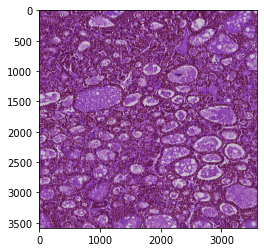

In [ ]:
predict_picture('/content/drive/My Drive/FC_Pap/data_1_train_set_2/testing/FC/FC-3_e_10_9.png')

classification
>>>Papillary Carcinoma
probability
1.0


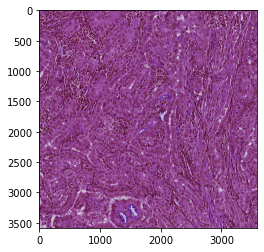

In [ ]:
predict_picture('/content/drive/My Drive/FC_Pap/data_1_train_set_2/testing/Pap/Pap-4_e_28_5.png')

※Grad CAM は別ノートにて